<a href="https://colab.research.google.com/github/tej1991/Image_Captioning./blob/master/omg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Load libraries
import pandas as pd
import pickle
import numpy as np
import os
import tensorflow as tf
from keras.applications.resnet50 import ResNet50
from keras.optimizers import Adam
from keras.layers import Dense, Flatten,Input, Convolution2D, Dropout, LSTM, TimeDistributed, Embedding, Bidirectional, Activation, RepeatVector,Concatenate
from keras.models import Sequential, Model
from keras.utils import np_utils
import random
from keras.preprocessing import image, sequence
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
#Mounting Drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
#Loading Data Files
images_dir = os.listdir("/content/gdrive/My Drive/")

images_path = '/content/gdrive/My Drive/Flicker8k_Dataset/'
captions_path = '/content/gdrive/My Drive/Flickr8k_text/Flickr8k.token.txt'
train_path = '/content/gdrive/My Drive/Flickr8k_text/Flickr_8k.trainImages.txt'
val_path = '/content/gdrive/My Drive/Flickr8k_text/Flickr_8k.devImages.txt'
test_path = '/content/gdrive/My Drive/Flickr8k_text/Flickr_8k.testImages.txt'

captions = open(captions_path, 'r').read().split("\n")
x_train = open(train_path, 'r').read().split("\n")
x_val = open(val_path, 'r').read().split("\n")
x_test = open(test_path, 'r').read().split("\n")

In [4]:
len(x_train)

6001

In [5]:
print(len(captions))
captions[:3]

40461


['1000268201_693b08cb0e.jpg#0\tA child in a pink dress is climbing up a set of stairs in an entry way .',
 '1000268201_693b08cb0e.jpg#1\tA girl going into a wooden building .',
 '1000268201_693b08cb0e.jpg#2\tA little girl climbing into a wooden playhouse .']

In [6]:
#Tokenizing Captions
tokens = {}

for ix in range(len(captions)-1):
    temp = captions[ix].split("#")
    if temp[0] in tokens:
        tokens[temp[0]].append(temp[1][2:])
    else:
        tokens[temp[0]] = [temp[1][2:]]

tokens

{'1000268201_693b08cb0e.jpg': ['A child in a pink dress is climbing up a set of stairs in an entry way .',
  'A girl going into a wooden building .',
  'A little girl climbing into a wooden playhouse .',
  'A little girl climbing the stairs to her playhouse .',
  'A little girl in a pink dress going into a wooden cabin .'],
 '1001773457_577c3a7d70.jpg': ['A black dog and a spotted dog are fighting',
  'A black dog and a tri-colored dog playing with each other on the road .',
  'A black dog and a white dog with brown spots are staring at each other in the street .',
  'Two dogs of different breeds looking at each other on the road .',
  'Two dogs on pavement moving toward each other .'],
 '1002674143_1b742ab4b8.jpg': ['A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .',
  'A little girl is sitting in front of a large painted rainbow .',
  'A small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it .',
  'T

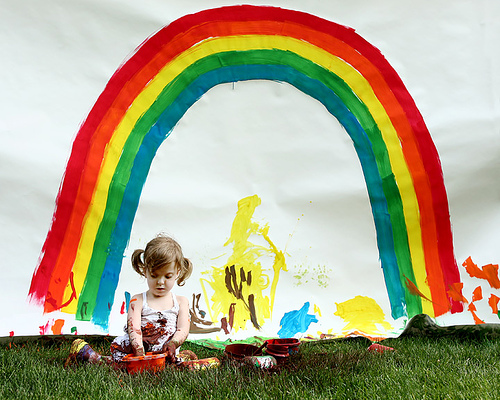

A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .
A little girl is sitting in front of a large painted rainbow .
A small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it .
There is a girl with pigtails sitting in front of a rainbow painting .
Young girl with pigtails painting outside in the grass .


In [7]:
#Displaying Image and its Caption
import random
index = random.randint(0, len(tokens))
temp = captions[10].split("#")
from IPython.display import Image, display
z = Image(filename=images_path+temp[0])
display(z)

# Loading captions as values and images as key in dictionary
for ix in range(len(tokens[temp[0]])):
    print(tokens[temp[0]][ix])

In [8]:
# Populating the above created files for train dataset with image ids and captions for each of these images
x_train_imgs=[]
captions=[]
for img in x_train:
    if img == '':
        continue
    for capt in tokens[img]:
        caption = "<start> "+ capt + " <end>"
        x_train_imgs.append(img)
        captions.append(caption)

In [9]:
# Loading image and its corresponding caption into a dataframe and then storing values from dataframe into 'train'
data={'images':x_train_imgs,'captions':captions}
train=pd.DataFrame(data)
train.head()

,images,captions
0,2513260012_03d33305cf.jpg,<start> A black dog is running after a white d...
1,2513260012_03d33305cf.jpg,<start> Black dog chasing brown dog through sn...
2,2513260012_03d33305cf.jpg,<start> Two dogs chase each other across the s...
3,2513260012_03d33305cf.jpg,<start> Two dogs play together in the snow . <...
4,2513260012_03d33305cf.jpg,<start> Two dogs running through a low lying b...


## Building Vocabulary

In [10]:
# Storing all the captions from train into a list
sentences = []
for ix in range(train.shape[0]):
    sentences.append(train)
    
print(len(sentences))

30000


In [11]:
# Splitting each captions stored in 'captions' and storing them in 'words' as list of list

words = [i.split() for i in captions]


In [12]:
# Creating a list of all unique words
unique = []
for i in words:
    unique.extend(i)
unique = list(set(unique))

print(len(unique))

vocab_size = len(unique)

8253


In [13]:
word_2_indices = {val:index for index, val in enumerate(unique)}
indices_2_word = {index:val for index, val in enumerate(unique)}

In [14]:
word_2_indices['UNK'] = 0
indices_2_word[0] = 'UNK'


In [15]:
indices_2_word[0] = 'UNK'
indices_2_word[8253] = 'raining'

In [16]:
print(word_2_indices['<start>'])
print(indices_2_word[4011])
print(word_2_indices['<end>'])
print(indices_2_word[8051])

5582
baby
5390
whisper


In [17]:
vocab_size = len(word_2_indices.keys())
print(vocab_size)

8254


In [18]:
max_len = 0
for i in captions:
    i = i.split()
    if len(i) > max_len:
        max_len = len(i)

print(max_len)

40


In [19]:
#Padding all Captions for uniform length of words 
padded_sequences, subsequent_words = [], []
for ix in tqdm(range(len(captions))):
    partial_seqs = []
    next_words = []
    text = captions[ix].split()
    text = [word_2_indices[i] for i in text]
    for i in range(1, len(text)):
        partial_seqs.append(text[:i])
        next_words.append(text[i])
    padded_partial_seqs = sequence.pad_sequences(partial_seqs, max_len, padding='post')
    next_words_1hot = np.zeros([len(next_words), vocab_size], dtype=np.bool)
    
    for i,next_word in enumerate(next_words):
        next_words_1hot[i, next_word] = 1
        
    padded_sequences.append(padded_partial_seqs)
    subsequent_words.append(next_words_1hot)

100%|██████████| 30000/30000 [00:03<00:00, 8025.50it/s]


## Image Processing

In [20]:
model = ResNet50(include_top=False,weights='imagenet',input_shape=(224,224,3),pooling='avg')
model.summary()

94773248/94765736 [==============================] - 1s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
__________________________

In [21]:
# Helper function to process images
def preprocessing(img_path):
    im = image.load_img(img_path, target_size=(224,224,3))
    im = image.img_to_array(im)
    im = np.expand_dims(im, axis=0)
    return im

In [22]:
imgs={}
for i in tqdm(x_train[:6000]):
    if i in imgs.keys():
        continue
    path = images_path + i
    img = preprocessing(path)
    pred = model.predict(img).reshape(2048)
    imgs[i]=pred

100%|██████████| 6000/6000 [38:22<00:00,  2.61it/s]


In [23]:
len(imgs)

6000

In [24]:
#Serializing IMAGES
with open( "proces_imgs.p", "wb" ) as pickle_f:
    pickle.dump(imgs, pickle_f )

In [25]:
with open('/content/proces_imgs.p', 'rb') as f:
    imgs= pickle.load(f, encoding="bytes")

In [26]:
img = []
for i in tqdm(range(train.shape[0])):
    if train.iloc[i, 0] in imgs.keys():
        img.append(imgs[train.iloc[i, 0]])

img = np.asarray(img)
print(img.shape)

100%|██████████| 30000/30000 [00:00<00:00, 68967.15it/s]


(30000, 2048)


# the Model

In [27]:
embedding_size = 128
image_model = Sequential()
image_model.add(Dense(embedding_size, input_shape=(2048,), activation='relu'))
image_model.add(RepeatVector(max_len))

image_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               262272    
_________________________________________________________________
repeat_vector (RepeatVector) (None, 40, 128)           0         
Total params: 262,272
Trainable params: 262,272
Non-trainable params: 0
_________________________________________________________________


In [28]:
language_model = Sequential()
language_model.add(Embedding(input_dim=vocab_size, output_dim=embedding_size, input_length=max_len))
language_model.add(LSTM(256, return_sequences=True))
language_model.add(TimeDistributed(Dense(embedding_size)))

language_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 40, 128)           1056512   
_________________________________________________________________
lstm (LSTM)                  (None, 40, 256)           394240    
_________________________________________________________________
time_distributed (TimeDistri (None, 40, 128)           32896     
Total params: 1,483,648
Trainable params: 1,483,648
Non-trainable params: 0
_________________________________________________________________


In [29]:
conca = Concatenate()([image_model.output, language_model.output])
x = LSTM(128, return_sequences=True)(conca)
x = LSTM(512, return_sequences=False)(x)
x = Dense(vocab_size)(x)
out = Activation('softmax')(x)
model = Model(inputs=[image_model.input, language_model.input], outputs = out)

In [30]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
embedding_input (InputLayer)    [(None, 40)]         0                                            
__________________________________________________________________________________________________
dense_input (InputLayer)        [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 40, 128)      1056512     embedding_input[0][0]            
__________________________________________________________________________________________________
dense (Dense)                   (None, 128)          262272      dense_input[0][0]                
_______________________________________________________________________________________

In [ ]:
model.load_weights('/content/gdrive/My Drive/best_model_acc.h5')

In [ ]:
def tr_gen(inp,ne_words,batch_size=64):
    cap=inp[1]
    imgs=inp[0]
    while True:
        for i in range(0,30000-batch_size,batch_size):
            n_words=[]
            i_cap=[]
            im=[]
            for j in range(batch_size):
                n_words.extend(ne_words[i+j].tolist())
                i_cap.extend(cap[i+j].tolist())
            for ix in range(i,i+batch_size):
                for iy in range(cap[ix].shape[0]):
                    im.append(imgs[ix])
                
            i_cap=np.array(i_cap)
            n_words=np.asarray(n_words)
            im= np.asarray(im)
        
            yield [im,i_cap],n_words

In [ ]:
train_gen=tr_gen([img,padded_sequences],subsequent_words,batch_size=64)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
MCP = ModelCheckpoint('best_model.h5', monitor = 'accuracy' , mode = 'max', verbose = 2 , save_best_only = True)

In [48]:
hist=model.fit(train_gen,steps_per_epoch=200,callbacks = [MCP],epochs=100)

Epoch 1/100
200/200 [==============================] - ETA: 0s - loss: 1.6853 - accuracy: 0.5601
Epoch 00001: accuracy improved from 0.55699 to 0.56008, saving model to best_model.h5
200/200 [==============================] - 76s 378ms/step - loss: 1.6853 - accuracy: 0.5601
Epoch 2/100
200/200 [==============================] - ETA: 0s - loss: 1.6752 - accuracy: 0.5603
Epoch 00002: accuracy improved from 0.56008 to 0.56026, saving model to best_model.h5
200/200 [==============================] - 76s 378ms/step - loss: 1.6752 - accuracy: 0.5603
Epoch 3/100
200/200 [==============================] - ETA: 0s - loss: 1.6592 - accuracy: 0.5648
Epoch 00003: accuracy improved from 0.56026 to 0.56480, saving model to best_model.h5
200/200 [==============================] - 76s 378ms/step - loss: 1.6592 - accuracy: 0.5648
Epoch 4/100
200/200 [==============================] - ETA: 0s - loss: 1.6402 - accuracy: 0.5684
Epoch 00004: accuracy improved from 0.56480 to 0.56841, saving model to best_m



## Predictions

In [49]:
def preprocessing(img_path):
    im = image.load_img(img_path, target_size=(224,224,3))
    im = image.img_to_array(im)
    im = np.expand_dims(im, axis=0)
    return im

In [50]:
def get_encoding(model, img):
    image = preprocessing(img)
    pred = model.predict(image).reshape(2048)
    return pred

In [51]:
resnet = ResNet50(include_top=False,weights='imagenet',input_shape=(224,224,3),pooling='avg')

In [58]:
#img = '/content/gdrive/My Drive/Flicker8k_Dataset/1012212859_01547e3f17.jpg'
img='/content/gdrive/My Drive/Flicker8k_Dataset/280706862_14c30d734a.jpg'
test_img = get_encoding(resnet, img)

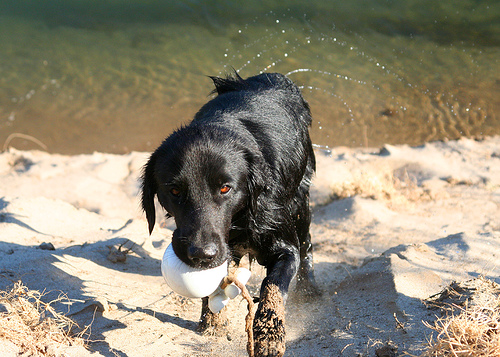

A black dog shaking water off .


In [59]:
def predict_captions(image):
    start_word = ["<start>"]
    while True:
        par_caps = [word_2_indices[i] for i in start_word]
        par_caps = sequence.pad_sequences([par_caps], maxlen=max_len, padding='post')
        preds = model.predict([np.array([image]), np.array(par_caps)])
        word_pred = indices_2_word[np.argmax(preds[0])]
        start_word.append(word_pred)
        
        if word_pred == "<end>" or len(start_word) > max_len:
            break
            
    return ' '.join(start_word[1:-1])

Argmax_Search = predict_captions(test_img)
z = Image(filename=img)
display(z)

print(Argmax_Search)